# Aim of This Notebook

### THEORY REFERENCE: Carr, P. and Madan, D. (1999). $\textit{Option valuation using the fast Fourier transform}$, Journal of Computational Finance, 2, 61–73.

The aim of this notebook is to provide an example of usage of FFT-based methodologies for plain vanilla option pricing. 

> Advantages: semi-closed formula ($\to$fast), supports jumps diffusion or general Lévy processes (here just Merton and Kou are presented).

> Disadvantages: suitable only for plain vanilla options.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

class PlainVanillaOption:
    def __init__(self, strike, params, T, r, S0, model='Merton'):
        self.strike = strike
        self.params = params
        self.T = T
        self.r = r
        self.S0 = S0
        self.model = model
        
        self.validate_params()
    
    def validate_params(self):
        if not isinstance(self.strike, (int, float)):
            raise TypeError("Strike price must be a number.")
        if not isinstance(self.params, (list, tuple)):
            raise TypeError("Parameters must be a list or tuple.")
        if not isinstance(self.T, (int, float)):
            raise TypeError("Time to maturity must be a number.")
        if not isinstance(self.r, (int, float)):
            raise TypeError("Risk-free rate must be a number.")
        if not isinstance(self.S0, (int, float)):
            raise TypeError("Initial stock price must be a number.")
        if self.model not in ['Merton', 'Kou']:
            raise ValueError("Model must be either 'Merton' or 'Kou'.")
    
    def CharFunc(self, v):
        if self.model == 'Merton':
            return self.CharFuncM(v)
        elif self.model == 'Kou':
            return self.CharFuncK(v)
    
    def CharFuncM(self, v):
        sigma, lambd, muJ, sigmaJ = self.params
        V = lambda u: -sigma**2 * u**2 / 2 + lambd * (np.exp(-sigmaJ**2 * u**2 / 2 + 1j * muJ * u) - 1)
        drift_rn = -V(-1j)
        return np.exp(self.T * (drift_rn * 1j * v + V(v)))
    
    def CharFuncK(self, v):
        sigma, lambd, p, lambdap, lambdam = self.params
        V = lambda u: -sigma**2 * u**2 / 2 + 1j * u * lambd * (p / (lambdap - 1j * u) - (1 - p) / (lambdam + 1j * u))
        drift_rn = -V(-1j)
        return np.exp(self.T * (drift_rn * 1j * v + V(v)))

    def price(self, plot=True):
        Npow = 10
        N = 2**Npow
        A = 1000
        eta = A / N 
        
        v = np.arange(0, A * (N - 1) / N, eta)
        v[0] = 1e-22
        
        lambd = 2 * np.pi / A
        k = -lambd * N / 2 + lambd * np.arange(N-1)
        
        Z_k = np.exp(1j * self.r * v * self.T) * (self.CharFunc(v - 1j) - 1) / (1j * v * (1j * v + 1))
        
        w = np.ones(N-1)
        w[[0, -1]] = 0.5
        x = w * eta * Z_k * np.exp(1j * np.pi * np.arange(N-1))
        z_k = np.real(np.fft.fft(x) / np.pi)
        C = self.S0 * (z_k + np.maximum(1 - np.exp(k - self.r * self.T), 0))
        K = self.S0 * np.exp(k)
        
        index = np.where((K > 0.3 * self.S0) & (K < 3 * self.S0))
        C = C[index]
        K = K[index]
        P = C - self.S0 + np.exp(- self.r * self.T) * K 
        
        if plot:
            plt.plot(K, C, label= 'Call Option')
            plt.plot(K, P, label= 'Put Option')
            plt.title(f'Carr & Madan Pricing for {self.model} model.')
            plt.xlabel('Strikes')
            plt.ylabel('Price')
            plt.legend()
            plt.show()
        
        return interp1d(K, C, kind='cubic')(self.strike), interp1d(K, P, kind='cubic')(self.strike)

In [2]:
# Example usage
strike = 100
paramsK = [0.2, 2.0, 0.5, 10, 5]
paramsM = [0.2, 0.1, 0, 1]
T = 1.0
r = 0.05
S0 = 100

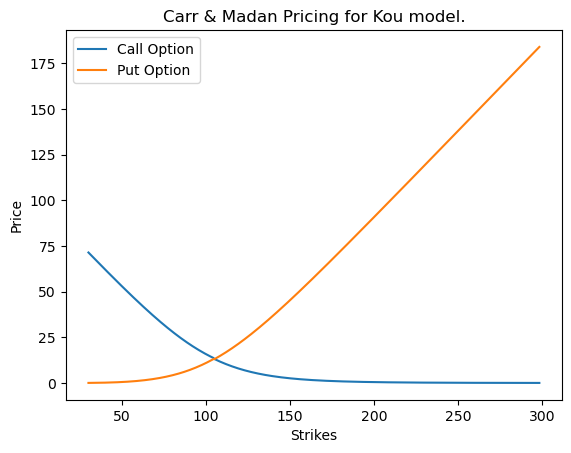

Call Option Price: 15.809664099862397, Put Option Price: 10.932606549933809


In [3]:
option = PlainVanillaOption(strike, paramsK, T, r, S0, model='Kou')
price = option.price(plot=True)
print(f"Call Option Price: {price[0]}, Put Option Price: {price[1]}")

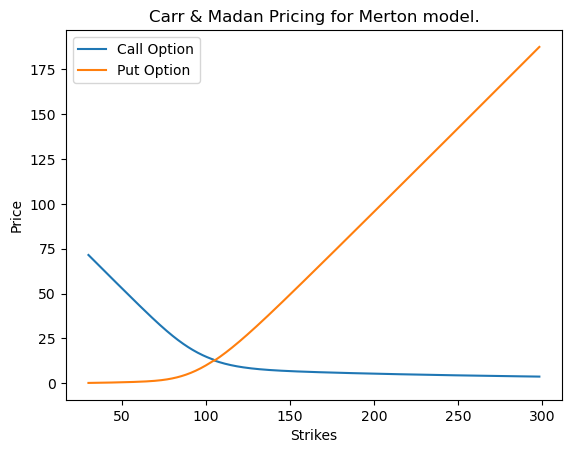

Call Option Price: 14.793087126943465, Put Option Price: 9.916029577014868


In [4]:
option = PlainVanillaOption(strike, paramsM, T, r, S0, model='Merton')
price = option.price(plot=True)
print(f"Call Option Price: {price[0]}, Put Option Price: {price[1]}")